In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# Random Forest
from sklearn.ensemble import RandomForestClassifier



In [4]:
train = pd.read_csv(r"C:\Users\Divyanshi\OneDrive\Documents\application_train.csv")

print(train.shape)
train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
num_feats = ['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START']

cat_feats = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
             'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
             'FLAG_DOCUMENT_3','FLAG_DOCUMENT_6','REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
             'LIVE_CITY_NOT_WORK_CITY','REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']

features = num_feats + cat_feats

In [6]:
print(len(num_feats))
print(len(cat_feats))
print(len(features))

5
15
20


In [7]:
num_transformer = Pipeline (
    steps = [
        ('imputer', SimpleImputer(strategy = 'mean')),
        ('scaler', StandardScaler())
    ]
)

cat_transformer = Pipeline (
    steps = [
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Missing')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)        
        

preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_feats),
        ('cat', cat_transformer, cat_feats)
    ]
)

In [8]:
preprocessor.fit(train[features])

X = preprocessor.transform(train[features])
y = train['TARGET']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f' Shape of X_train: {X_train.shape}','\n',
      f'Shape of y_train: {y_train.shape}')

print(f' Shape of X_test: {X_test.shape}','\n',
      f'Shape of y_test: {y_test.shape}')


 Shape of X_train: (246008, 55) 
 Shape of y_train: (246008,)
 Shape of X_test: (61503, 55) 
 Shape of y_test: (61503,)


In [9]:
%%time

dt_clf = DecisionTreeClassifier(random_state=1)

dt_parameters = {
    'max_depth': [15,16,17],
    'min_samples_leaf': [256,512,1024]
}

dt_grid = GridSearchCV(dt_clf, dt_parameters, cv=2, refit='True', n_jobs=-1, verbose=0, scoring= 'roc_auc')
dt_grid.fit(X_train, y_train)

dt_model = dt_grid.best_estimator_

print('Best Parameters:', dt_grid.best_params_)
print('Best CV Score:  ', dt_grid.best_score_)
print('Training Acc:   ', dt_model.score(X_train, y_train))

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1024}
Best CV Score:   0.6378425226856735
Training Acc:    0.9195351370687133
CPU times: total: 2.77 s
Wall time: 17.9 s


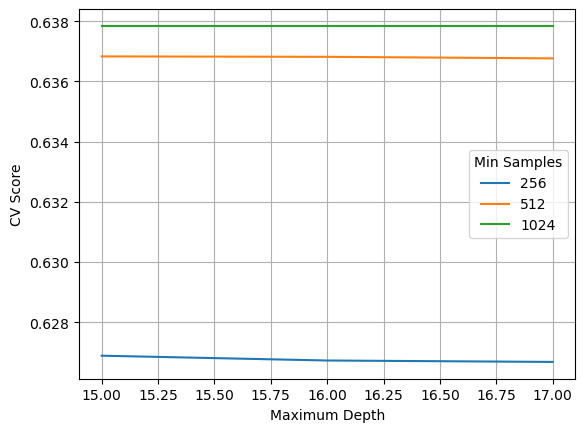

 max_depth  min_samples_leaf  cv_score
        15               256  0.626889
        15               512  0.636830
        15              1024  0.637843
        16               256  0.626729
        16               512  0.636816
        16              1024  0.637843
        17               256  0.626682
        17               512  0.636765
        17              1024  0.637843


In [10]:
dt_summary = pd.DataFrame(dt_grid.cv_results_['params'])
dt_summary['cv_score'] = dt_grid.cv_results_['mean_test_score']

for ms in dt_parameters['min_samples_leaf']:
    temp = dt_summary.query(f'min_samples_leaf == {ms}')
    plt.plot(temp.max_depth, temp.cv_score, label=ms)
plt.xlabel('Maximum Depth')
plt.ylabel('CV Score')
plt.legend(title='Min Samples')
plt.grid()
plt.show()

print(dt_summary.to_string(index=False))

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import *


class BayesianOptimizer:
    """
    Bayseian Optimizer for hyperparameter optimization
    """
    def __init__( self,
            func,
            float_param_ranges={},
            int_param_candidates={},
            n_init_points=10000,
            external_init_points=None,
            max_iter=1e4,
            no_new_converge=3,
            no_better_converge=10,
            kernel=RBF(),
            acq_type='PI',
            beta_lcb=0.5,
            eps=1e-7,
            n_sample=int(1e6),
            seed=None,
            model_class = DecisionTreeClassifier):
       
        self.func = func
        self.float_param_dict = float_param_ranges
        self.int_param_dict = int_param_candidates

        # bayesian optimization hyper-hyper-parameters
        self.max_iter = int(max_iter)
        self.no_new_converge = no_new_converge
        self.no_better_converge = no_better_converge
        self.acq_type = acq_type
        self.beta_LCB = beta_lcb
        self.eps = eps
        self.n_sample = n_sample
        self.n_init_points = n_init_points
        self.model_class = model_class

        # random seed
        self.seed = seed

        # the underlying Gaussian Process Regression for bayesian optimization
        self.gpr = GPR(
            kernel=kernel,
            n_restarts_optimizer=50,
            random_state=self.seed
        )

        # parse hyperparameters' names
        self.__parse_param_names()

        # get float parameters' ranges and integer parameters' candidates
        self.__get_ranges_and_candidates()

        # get starting points
        self.init_points = self.__get_init_points(external_init_points)

        self.x = self.init_points

        # initialize with points and their functional values
        print('Evaluating Initial Points...')
       

        self.y = np.zeros(shape= (self.init_points.shape[0],))
        itr =0
        for p in self.init_points:
            asd = dict(zip(self.param_names,p))
            val = self.func(self.model_class,asd)
            y[itr] = val
            itr +=1
 
        
        self.num_param_seeds = len(self.x)

        # initial fit for GPR
        self.gpr.fit(self.x, self.y)

    def __parse_param_names(self):
        self.float_param_names = list(self.float_param_dict.keys())
        self.int_param_names = list(self.int_param_dict.keys())
        self.param_names = self.float_param_names + self.int_param_names

    def __get_ranges_and_candidates(self):
        self.float_param_ranges = np.array(list(self.float_param_dict.values()))
        self.int_param_candidates = list(self.int_param_dict.values())

    def __get_init_points(self, external_init_points):
        internal_init_points = self.__generate_random_params(self.n_init_points)

       
        if external_init_points is not None:
            nums = np.array([len(choices) for choices in external_init_points.values()])
            if not all(nums == nums[0]):
                raise Exception('Number of values for each parameter must be the same')
            if nums.sum() != 0:
                # combine with user's input points in array, list, tuple
                points = []
                for param in self.param_names:
                    points.append(external_init_points[param])
                # points shape: [param, choices] transpose to [n point, param]
                points = np.array(points).T
                internal_init_points = np.vstack((internal_init_points, points))

        u_index = self.__unique_index(internal_init_points)
        return internal_init_points[u_index]

    def __check_int_param(self, param_dict):
        for k, v in param_dict.items():
            if k in self.int_param_names:
                param_dict[k] = int(param_dict[k])
        return param_dict

    def __generate_random_params(self, n):
        np.random.seed(self.seed)
        if (self.float_param_ranges.size != 0):

            xs_range = np.random.uniform(
                low=self.float_param_ranges[:, 0],
                high=self.float_param_ranges[:, 1],
                size=(int(n), self.float_param_ranges.shape[0])
            )
        xs_candidates = np.array([np.random.choice(self.int_param_dict[choice], size=int(n)) for choice in self.int_param_dict])
        xs_candidates = xs_candidates.T
        if (self.float_param_ranges.size == 0):
            return (xs_candidates)
        else:    
            return np.hstack((xs_range, xs_candidates))

    def __unique_index(self, xs):

        uniques = np.unique(xs, axis=0)
        if len(uniques) == len(xs):
            return list(range(len(xs)))
        
        uniques_tuple = tuple(tuple(row) for row in uniques)

        counter = {u: 0 for u in uniques_tuple}

        indices = []
        for i, x in enumerate(xs):
            if counter[x] == 0:
                counter[x] += 1
                indices.append(i)
        return indices

    def __acquisition_func(self, xs):
        print('Calculating utility Acquisition on sampled points based on GPR...')
        # calculate the utility of f(x) given a number of x s, regard to mean and sd
        means, sds = self.gpr.predict(xs, return_std=True)
        # Setting variance below 0 to 0
        sds[sds < 0] = 0
        # eps prevent overflow of dividing small number
        z = (self.y.min() - means) / (sds + self.eps)

        # implementation of EI, expected improvement
        if self.acq_type == 'EI':
            return (self.y.min() - means) * norm.cdf(z) + sds * norm.pdf(z)
        # implementation of PI, probability of improvement
        if self.acq_type == 'PI':
            return norm.pdf(z)
        # implementation of LCB, optimistic lower confidence bound
        if self.acq_type == 'LCB':
            return means - self.beta_LCB * sds

    def __min_acquisition(self, n=1e6):
        print('Random sampling based on ranges and candidates...')
        xs = self.__generate_random_params(n)
        ys = self.__acquisition_func(xs)
        return xs[ys.argmin()]

    def optimize(self):
        no_new_converge_counter = 0
        no_better_converge_counter = 0
        best = self.y.min()
        for i in range(self.max_iter):
            print('Iteration: {}, Current Best: {}'.format(i, self.y.min()))
            # check convergence
            if no_new_converge_counter > self.no_new_converge:  # no more new combination
                break
            if no_better_converge_counter > self.no_better_converge:  # no more better combination
                break

            # get one better sample from current estimated landscape
            next_best_x = self.__min_acquisition(self.n_sample)

            # if x_best has been sampled before, redo sampling by going to next round
            if np.any((self.x - next_best_x).sum(axis=1) == 0):
                no_new_converge_counter += 1
                continue

            print('Iteration {}: evaluating guessed best param set by evaluation function...'.format(i))
            self.x = np.vstack((self.x, next_best_x))
            # next_best_y = self.func(**self.__check_int_param(dict(zip(self.param_names, next_best_x))))
            next_best_y = self.func(self.model_class, (dict(zip(self.param_names, next_best_x))))
            self.y = np.append(self.y, next_best_y)

            print('Iteration {}: next best is {}, {}'.format(i, next_best_y, dict(zip(self.param_names, next_best_x))))

            u_index = self.__unique_index(self.x)

            for i in u_index:
                self.x = self.x[u_index]
                self.y = self.y[u_index]
                
            if self.y.min() < best:
                no_better_converge_counter = 0
                best = self.y.min()
            else:
                no_better_converge_counter += 1

            # check new combination
            if len(self.x) == self.num_param_seeds:
                no_new_converge_counter += 1
            else:
                no_new_converge_counter = 0
                self.num_param_seeds = len(self.x)

            # re-fit GPR after collecting more samples (combinations)
            print('Iteration {}: re-fit GPR with updated parameter sets'.format(i))
            self.gpr.fit(self.x, self.y)

    def get_results(self):
        num_init = len(self.init_points)
        num_new = len(self.y) - num_init
        is_init = np.array([1] * num_init + [0] * num_new).reshape((-1, 1))
        results = pd.DataFrame(
            np.hstack((self.x, self.y.reshape((-1, 1)), is_init)),
            columns=self.param_names+['AvgTestCost', 'isInit']
        )

        return results.sort_values(by='AvgTestCost', inplace=False)

In [12]:
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score
def objective_function(model_class, params):
   
    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy

float_param_ranges = {}
int_param_candidates = {
    'max_depth': list(np.arange(11,21)),
    'min_samples_leaf': list(np.arange(1010,1030))
}



optimizer = BayesianOptimizer(
    func=objective_function,
    float_param_ranges=float_param_ranges,
    int_param_candidates=int_param_candidates,
    n_init_points=5,
    max_iter=2000,
    model_class= RandomForestClassifier
)
optimizer.optimize()
hyper_setting = optimizer.get_results()

print(hyper_setting)

best_score = -hyper_setting.iloc[0]['AvgTestCost']
best_params = hyper_setting.iloc[0][:-2].to_dict()
print('Best_score: ', best_score )
print('Best Params: ', best_params)

Evaluating Initial Points...


C:\Users\Divyanshi\AppData\Local\Temp\ipykernel_10856\1962179037.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[itr] = val
C:\Users\Divyanshi\Downloads\New folder\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration: 0, Current Best: 0.0
Random sampling based on ranges and candidates...
Calculating utility Acquisition on sampled points based on GPR...
Iteration: 1, Current Best: 0.0
Random sampling based on ranges and candidates...
Calculating utility Acquisition on sampled points based on GPR...
Iteration 1: evaluating guessed best param set by evaluation function...
Iteration 1: next best is -0.918215371607889, {'max_depth': 11, 'min_samples_leaf': 1014}
Iteration 5: re-fit GPR with updated parameter sets
Iteration: 2, Current Best: -0.918215371607889
Random sampling based on ranges and candidates...
Calculating utility Acquisition on sampled points based on GPR...
Iteration: 3, Current Best: -0.918215371607889
Random sampling based on ranges and candidates...
Calculating utility Acquisition on sampled points based on GPR...
Iteration: 4, Current Best: -0.918215371607889
Random sampling based on ranges and candidates...
Calculating utility Acquisition on sampled points based on GPR...


In [13]:
model_using_bayesian = DecisionTreeClassifier(max_depth = int(best_params['max_depth']), min_samples_leaf = int(best_params['min_samples_leaf']))


In [14]:
model_using_bayesian.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=1014)

In [15]:
from sklearn.model_selection import RandomizedSearchCV

def optimize_random_search(model, param_distributions, X_train, y_train, n_iter=10, cv=3, scoring='roc_auc'):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    return random_search.best_params_

In [16]:
param_distributions = {'max_depth':list(np.arange(11,21)),
'min_samples_leaf':list(np.arange(1010,1030))}

param_dict = optimize_random_search(DecisionTreeClassifier(),param_distributions, X_train, y_train)
print(param_dict)

{'min_samples_leaf': 1028, 'max_depth': 18}


In [17]:
# print(param_dict)
model_using_random_search = DecisionTreeClassifier(max_depth = param_dict['max_depth'], min_samples_leaf = param_dict['min_samples_leaf'])
model_using_random_search.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=18, min_samples_leaf=1028)

In [19]:
pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
Note: you may need to restart the kernel to use updated packages.


In [20]:

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.base import clone
from sklearn.metrics import accuracy_score

def hyperopt_objective(params, model, X_train, y_train, X_test, y_test):
    clf = clone(model).set_params(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

def optimize_hyperopt(model, param_space, X_train, y_train, X_test, y_test, max_evals=10):
    trials = Trials()
    best_params = fmin(
        fn=lambda params: hyperopt_objective(params, model, X_train, y_train, X_test, y_test),
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
    )
    return best_params

In [21]:

param_space = {"max_depth": scope.int(hp.quniform("max_depth", 11, 21, 1)),
             "min_samples_leaf": scope.int(hp.quniform("min_samples_leaf", 1020, 1030,1))}
print(param_space)

param_hyper = optimize_hyperopt(DecisionTreeClassifier(),param_space, X_train, y_train, X_test, y_test)

{'max_depth': <hyperopt.pyll.base.Apply object at 0x000001F3000D0670>, 'min_samples_leaf': <hyperopt.pyll.base.Apply object at 0x000001F3000D1EA0>}
100%|████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.21s/trial, best loss: -0.918215371607889]


In [22]:
param_hyper
model_using_hyperopt = DecisionTreeClassifier(max_depth = int(param_hyper['max_depth']), min_samples_leaf = int(param_hyper['min_samples_leaf']))

In [23]:
print(param_hyper)

{'max_depth': 17.0, 'min_samples_leaf': 1028.0}


In [24]:
model_using_hyperopt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=17, min_samples_leaf=1028)

# NEW CODE FOR EVAULATION

In [27]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_auc_curve(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')
    return auc_score


def calculate_cross_val_score(model, X_train, y_train):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    return cv_scores, mean_cv_score

def plot_learning_rate_distribution_curve(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)
    plt.hist(y_proba[:, 1], bins=30, alpha=0.5, label=label)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend(loc='best')




def plot_learning_curve(model, X, y, label, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label=f"Training score ({label})")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label=f"Cross-validation score ({label})")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(f'Learning Curve ({label})')
    
    
def evaluate_and_compare(models, X_train, y_train, X_test, y_test, labels, cv=5):
    plt.figure(figsize=(10, 7))
    
    for model, label in zip(models, labels):
        # ROC AUC
        auc_score = plot_roc_auc_curve(model, X_test, y_test, label)
        print(f"ROC AUC score ({label}):", auc_score)
        
        # Cross-validation scores
        cv_scores, mean_cv_score = calculate_cross_val_score(model, X_train, y_train)
        print(f"Cross-validation scores ({label}):", cv_scores)
        print(f"Mean CV score ({label}):", mean_cv_score)
        
        # Learning rate distribution curve
        plot_learning_rate_distribution_curve(model, X_test, y_test, label)
    

    plt.legend(loc='best')
    plt.show()

    # Plot learning curves
    for model, label in zip(models, labels):
        plt.figure(figsize=(10, 7))
        plot_learning_curve(model, X_train, y_train, label, cv=cv)
        plt.show()


ROC AUC score (Random_Search): 0.6457658050070479
Cross-validation scores (Random_Search): [0.91953579 0.91953579 0.91953579 0.91953416 0.91953416]
Mean CV score (Random_Search): 0.9195351370607359
ROC AUC score (Bayesian): 0.645501032724905
Cross-validation scores (Bayesian): [0.91953579 0.91953579 0.91953579 0.91953416 0.91953416]
Mean CV score (Bayesian): 0.9195351370607359
ROC AUC score (Hyperopt): 0.645501032724905
Cross-validation scores (Hyperopt): [0.91953579 0.91953579 0.91953579 0.91953416 0.91953416]
Mean CV score (Hyperopt): 0.9195351370607359


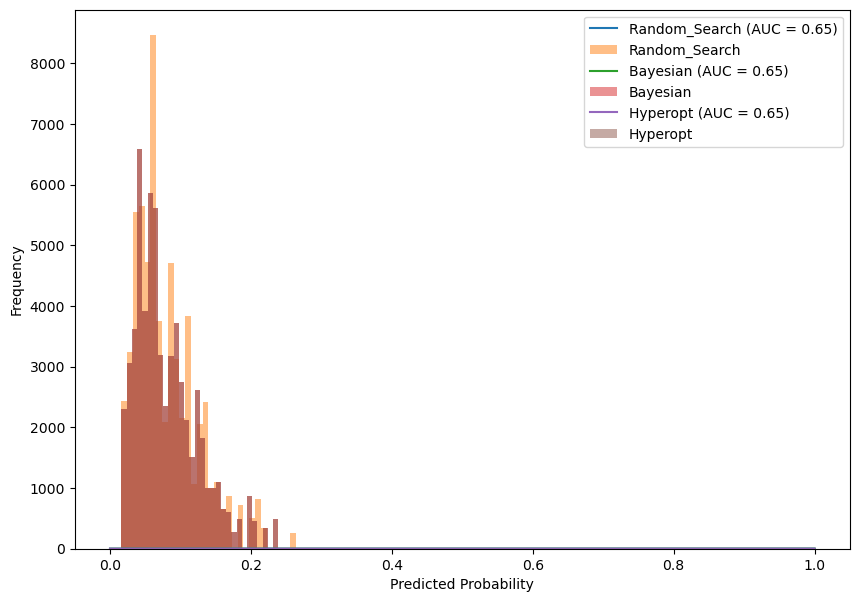

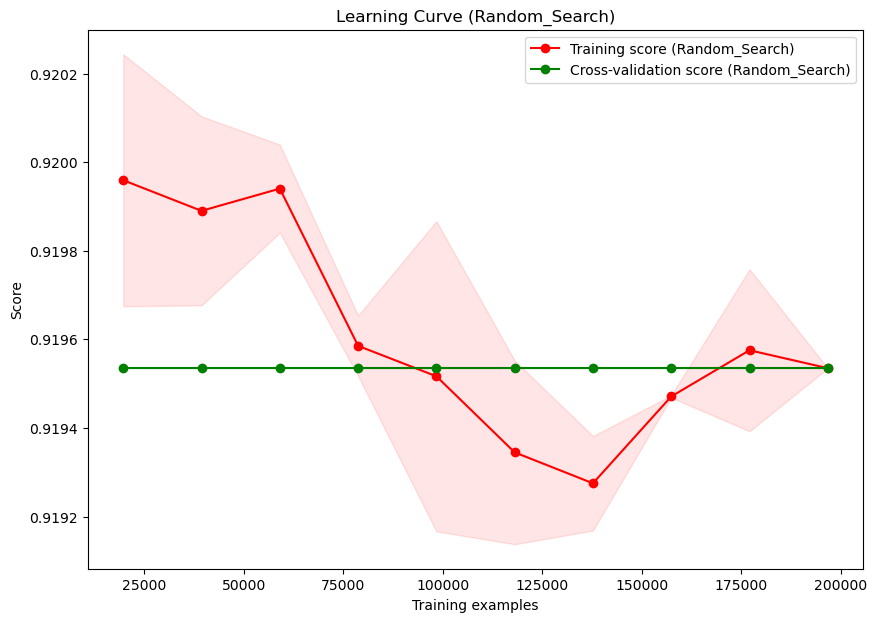

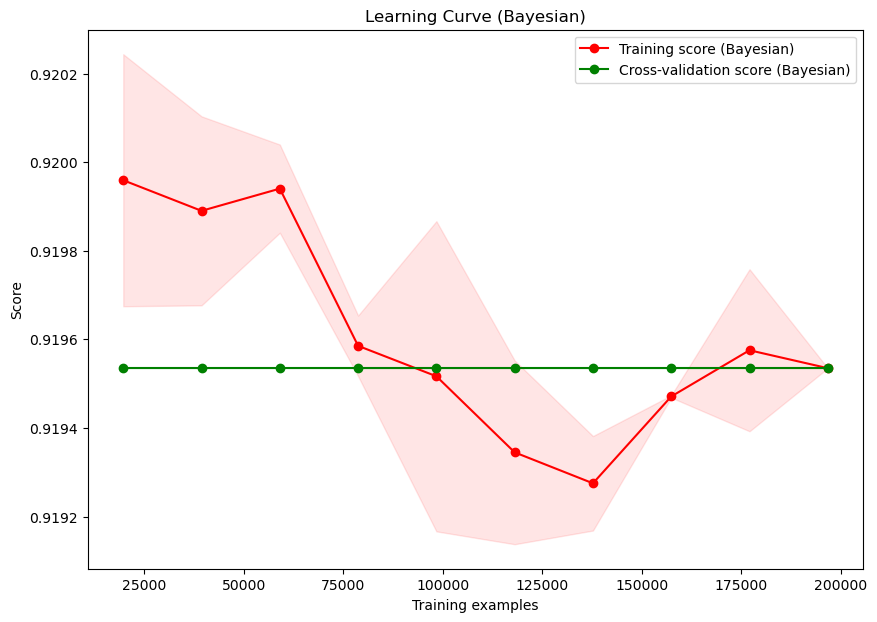

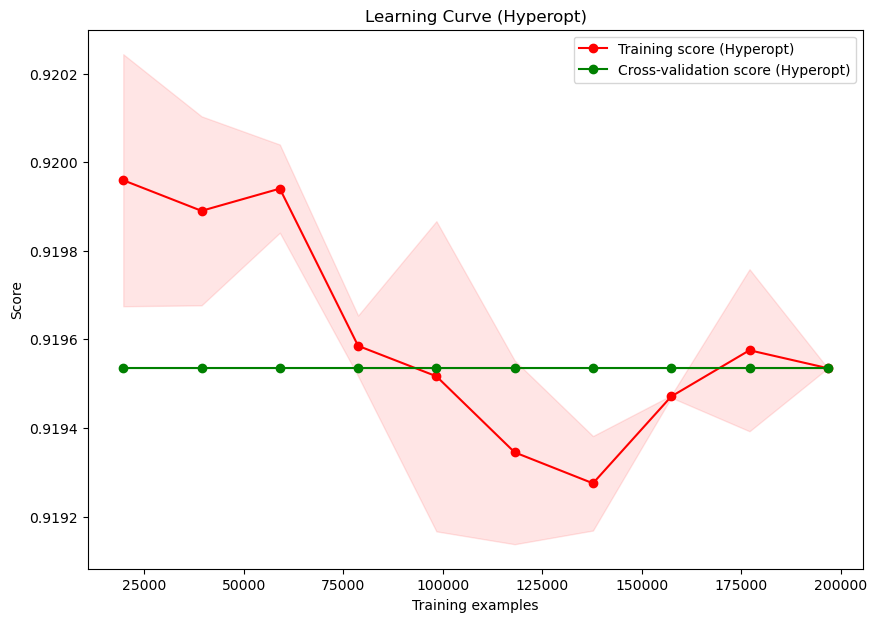

In [28]:
model_list = {
     model_using_random_search,
     model_using_hyperopt,
     model_using_bayesian
}
evaluate_and_compare(model_list, X_train, y_train, X_test, y_test, {"Random_Search","Hyperopt","Bayesian"}, cv=5)

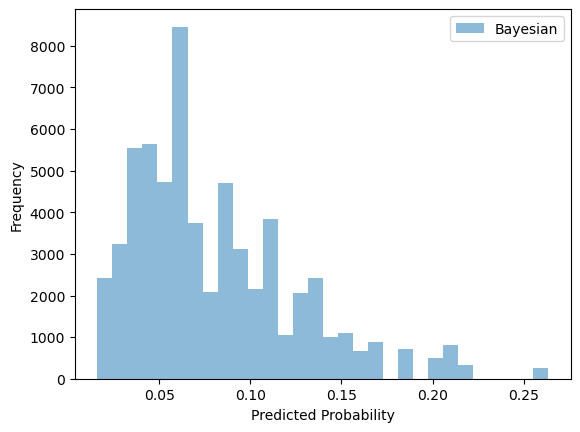

In [29]:
plot_learning_rate_distribution_curve(model_using_bayesian, X_test ,y_test, "Bayesian" )